# YouTube ライブコメント分析デモ
このサンプルコードでは、以下の動画（2021年の東京ゲームショーで発表された『モンスターハンターライズ：サンブレイク』最新情報ライブ配信）の視聴者コメントを分析し、視聴者が何に興味・関心を持っていたか分析しています。
https://www.youtube.com/watch?v=MCzITTAy8G8

In [5]:
!pip install -q mecab-python3
!pip install -q unidic
!python -m unidic download
!pip install japanize_matplotlib
!apt-get -y install fonts-ipafont-gothic > /dev/null
!pip install nlplot
!pip install altair

download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100%|██████████████████████| 526M/526M [00:25<00:00, 21.0MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /opt/conda/lib/python3.7/site-packages/unidic/dicdir
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [16]:
import pandas as pd
import altair as alt
import nlplot
import matplotlib.pyplot as plt
import MeCab
import datetime as dt
import re

In [28]:
df=pd.read_csv("MCzITTAy8G8.csv",names=["dt","name","comment","sentiment","magnitude"])
df['dt']=pd.to_datetime(df['dt'])
df['comment']=df['comment'].astype(str)
df['sentiment'] = pd.to_numeric(df['sentiment'], errors='coerce')
df['magnitude'] = pd.to_numeric(df['magnitude'], errors='coerce')

In [29]:
def mecab_text(text):
    mecab = MeCab.Tagger()
    node = mecab.parseToNode(text)
    wordlist = []
    
    while node:
        if node.feature.split(',')[0] == '名詞':
            wordlist.append(node.surface)
        elif node.feature.split(',')[0] == '形容詞':
            wordlist.append(node.surface)
        node = node.next
    return wordlist

df['words'] = df['comment'].apply(mecab_text)
df.head()

,dt,name,comment,sentiment,magnitude,words
0,2021-09-30 12:52:17,499人いったら声出す,CAPCOM頼むドスランポスはよ！,0.0,0.0,"[CAPCOM, ドス, ランポス]"
1,2021-09-30 12:52:18,ライダー,エスピナスください,-0.2,0.2,[エスピナス]
2,2021-09-30 12:52:19,kikui kikui,全ドスモンスター解禁,0.0,0.0,"[ドス, モンスター, 解禁]"
3,2021-09-30 12:52:19,浅葱部長,美味しそうなモンスター…,0.7,0.7,"[美味し, モンスター]"
4,2021-09-30 12:52:20,点P2,ホロロホルル,0.3,0.3,[ホロロホルル]


In [30]:
df_time=df.iloc[:,[0,3,4]].groupby(pd.Grouper(key='dt', freq='1min')).mean().reset_index()
df_cnt = df.iloc[:,[0,2]].groupby(pd.Grouper(key='dt', freq='1min')).count().reset_index()

In [32]:
c = alt.Chart(df_cnt).mark_line().encode(
    x='dt',
    y='comment',
).properties(height=100,width=600)
s = alt.Chart(df_time).mark_bar().encode(
    x="dt:T",
    y="sentiment:Q",
    color=alt.condition(
        alt.datum.nonfarm_change > 0,
        alt.value("steelblue"),  # The positive color
        alt.value("orange")  # The negative color
    )
).properties(height=100,width=600)
m = alt.Chart(df_time).mark_line().encode(
    x='dt',
    y='magnitude'
).properties(height=100,width=600)
alt.vconcat(c,s,m, data=df_time)

alt.VConcatChart(...)

13:06 アップデートイベント（魔界村コラボ）の発表
13:20 琵琶法師ライブ前後
13:35 PC版の発表

In [33]:
dfc = df['comment'].to_frame()
list = dfc['comment'].tolist()

In [35]:
# MeCabで特定の名詞だけ抜き取る
tagger = MeCab.Tagger()

def word_extraction(text):
    """特定名詞だけ抽出"""
    #URLを正規表現で排除
    result = re.sub("https?://[\w!\?/\+\-_~=;\.,\*&@#\$%\(\)'\[\]]+", "", text)
    parse = tagger.parse(result)

    lines = parse.split('\n') 
    nounlist = [] #特定名詞を格納
    for line in lines:
        feature = line.split('\t') #タブで区切る
        if len(feature) == 2: #'EOS'と''を省く
            info = feature[1].split(',')
            hinshi = info[0] #　品詞取得
            hinshi_classi = info[1] #　品詞分類を取得
            #名詞 - 一般,サ変,固有名詞　だけ抽出する　※抽出したいものに合わせてカスタマイズすればいい
            if (hinshi in ('名詞')) and ((hinshi_classi in ('一般')) or (hinshi_classi in ('サ変接続')) or (hinshi_classi in ('固有名詞'))):
                nounlist.append(feature[0]) #info[6]を取得してもいいが、今回は原文を取得
    return nounlist

# wordsカラムを追加
dfc['comment'] = dfc['comment'].apply(word_extraction)
df

,dt,name,comment,sentiment,magnitude,words
0,2021-09-30 12:52:17,499人いったら声出す,CAPCOM頼むドスランポスはよ！,0.0,0.0,"[CAPCOM, ドス, ランポス]"
1,2021-09-30 12:52:18,ライダー,エスピナスください,-0.2,0.2,[エスピナス]
2,2021-09-30 12:52:19,kikui kikui,全ドスモンスター解禁,0.0,0.0,"[ドス, モンスター, 解禁]"
3,2021-09-30 12:52:19,浅葱部長,美味しそうなモンスター…,0.7,0.7,"[美味し, モンスター]"
4,2021-09-30 12:52:20,点P2,ホロロホルル,0.3,0.3,[ホロロホルル]
...,...,...,...,...,...,...
14070,2021-09-30 13:51:46,カルナVAL,ごみー,0.3,0.3,[ごみ]
14071,2021-09-30 13:51:46,腹筋筋肉,乙,0.3,0.3,[乙]
14072,2021-09-30 13:51:47,ピカソピッケル,ネジキネジキネジキネジキネジキネジキネジキネジキネジキネジキネジキネジキネジキネジキネジキネ...,0.3,0.3,"[ネジ, キネ, ジキ, ネジ, キネ, ジキ, ネジ, キネ, ジキ, ネジ, キネ, ジ..."
14073,NaT,NaN,nan,0.0,0.0,[nan]


In [36]:
npt = nlplot.NLPlot(dfc, target_col='comment') #Tweets_dfのwordsカラムを解析対象にする
#stopwords = npt.get_stopword(top_n=4, min_freq=0) #ストップワードとして上記頻出4単語を排除する
#print(stopwords)
stopwords = ["カプコン"]

100%|██████████| 14075/14075 [00:00<00:00, 260573.85it/s]


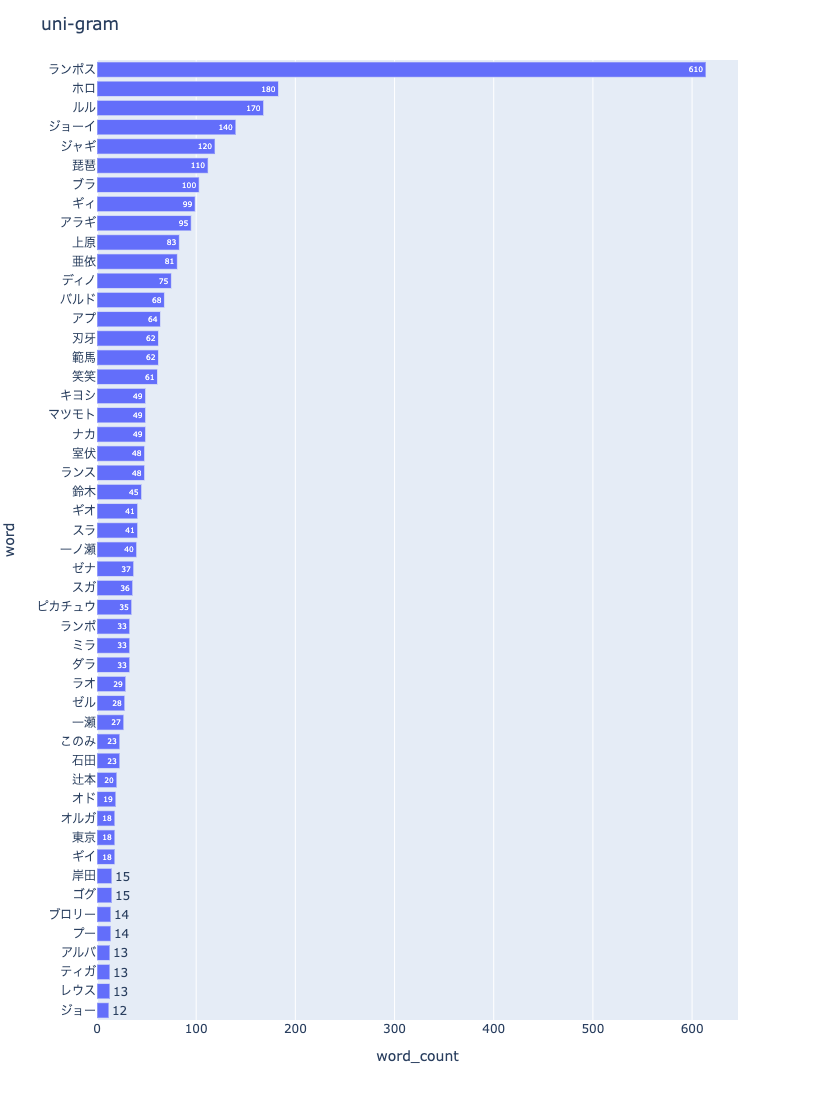

In [37]:
npt.bar_ngram(
    title='uni-gram',
    xaxis_label='word_count',
    yaxis_label='word',
    ngram=1,
    top_n=50,
    stopwords=stopwords,
)

100%|██████████| 14075/14075 [00:00<00:00, 259198.67it/s]


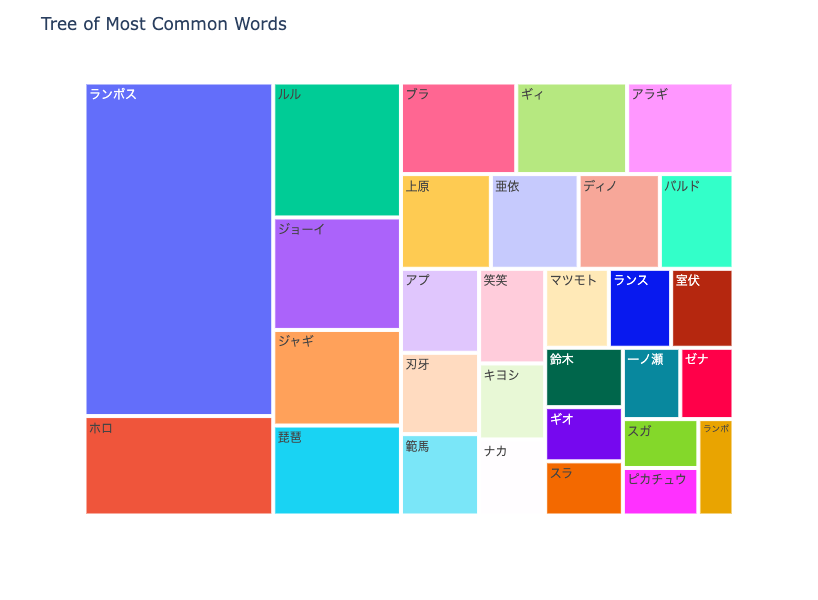

In [38]:
npt.treemap(
    title='Tree of Most Common Words',
    ngram=1,
    top_n=30,
    stopwords=stopwords,
)

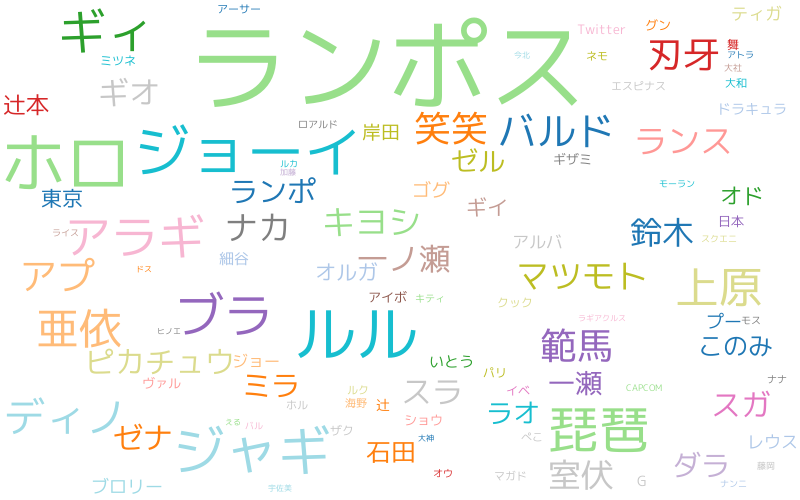

In [39]:
#nlplotのwordcloudを使用して可視化させる
npt.wordcloud(
    stopwords=stopwords, #設定したストップワードを排除
    max_words=100,
    max_font_size=100,
    colormap='tab20_r',
    save=True
)

In [40]:
npt.build_graph(stopwords=stopwords, min_edge_frequency=1)
#npt.edge_df.head()

node_size:43, edge_size:25


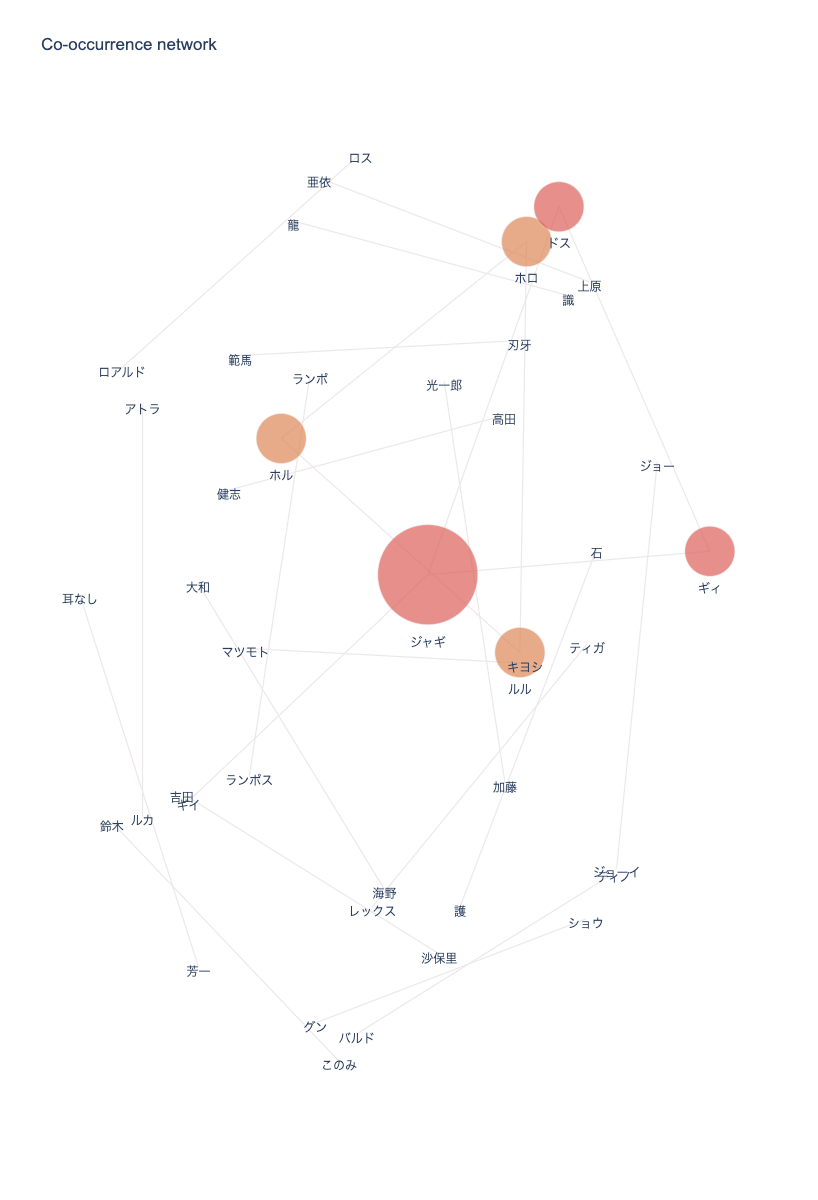

In [41]:
npt.co_network(
    title='Co-occurrence network',
)